In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


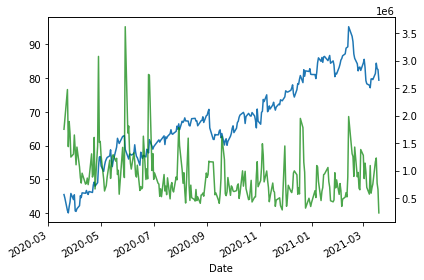

In [50]:
google=pd.read_csv('GOOG.csv',parse_dates=['Date'],index_col='Date')
netflix=pd.read_csv('nflx.csv',parse_dates=['Date'],index_col='Date')
nio=pd.read_csv('nio.csv',parse_dates=['Date'],index_col='Date')
dominos=pd.read_csv('dpz.csv',parse_dates=['Date'],index_col='Date')
disney=pd.read_csv('dis.csv',parse_dates=['Date'],index_col='Date')
apple=pd.read_csv('aapl.csv',parse_dates=['Date'],index_col='Date')
vmware=pd.read_csv('VMW.csv',parse_dates=['Date'],index_col='Date')
microsoft=pd.read_csv('MSFT.csv',parse_dates=['Date'],index_col='Date')
sp500=pd.read_csv('sp500.csv',parse_dates=['Date'],index_col='Date')
cisco=pd.read_csv('CSCO.csv',parse_dates=['Date'],index_col='Date')
tesla=pd.read_csv('TSLA.csv',parse_dates=['Date'],index_col='Date')
cgnx=pd.read_csv('CGNX.csv',parse_dates=['Date'],index_col='Date')

df=cgnx.copy()

#df['Date']=pd.to_datetime(df['Date'])
#df=df.set_index('Date')
df=df.sort_values(by='Date',ascending=True)
print(df.columns)
fig,ax=plt.subplots(figsize=(6,4))
df['Open'].plot(ax=ax)
twin_ax=ax.twinx()

df['Volume'].plot(ax=twin_ax, c='green', alpha=0.7)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



In [51]:
#df=df.asfreq('B').fillna(0)
#for key, item in df.iterrows():
#    print(key,item)

In [52]:
df['Shifted 1D']=df.Open.shift()
df['Shifted 2D']=df.Open.shift(periods=2)
df['Open_PCT']=df['Open'].pct_change()

df["Buy_Count"]=0

for index in range(len(df)):
    count=0
    for index2 in (range(index,0,-1)):
        if df.iloc[index2]["Open_PCT"]>0:
            count=count+1
        else:
            break
    df.iloc[index, df.columns.get_loc('Buy_Count')]=count
    
df['Action']=[ 'Sell' if x['Buy_Count']==0 else 'Buy' if x['Buy_Count']==2 else 'Hold' if x['Buy_Count'] > 2 else 'No Action' for key,x in df.iterrows()]

df["Target"]=0
for index in range(len(df)):
    action=df.iloc[index]["Action"]
    if (action=='Buy'):
             df.iloc[index, df.columns.get_loc('Target')]=1
    elif (action=='Sell'):
             df.iloc[index, df.columns.get_loc('Target')]=2

print(df[['Target','Action','Open_PCT','Open','Shifted 1D','Shifted 2D','Buy_Count']])



            Target     Action  Open_PCT       Open  Shifted 1D  Shifted 2D  \
Date                                                                         
2020-03-19       2       Sell       NaN  45.490002         NaN         NaN   
2020-03-20       2       Sell -0.022203  44.480000   45.490002         NaN   
2020-03-23       2       Sell -0.083858  40.750000   44.480000   45.490002   
2020-03-24       2       Sell -0.016687  40.070000   40.750000   44.480000   
2020-03-25       0  No Action  0.046419  41.930000   40.070000   40.750000   
...            ...        ...       ...        ...         ...         ...   
2021-03-15       0  No Action  0.022642  81.300003   79.500000   79.739998   
2021-03-16       1        Buy  0.037638  84.360001   81.300003   79.500000   
2021-03-17       2       Sell -0.019203  82.739998   84.360001   81.300003   
2021-03-18       2       Sell -0.003142  82.480003   82.739998   84.360001   
2021-03-19       2       Sell -0.038191  79.330002   82.480003  

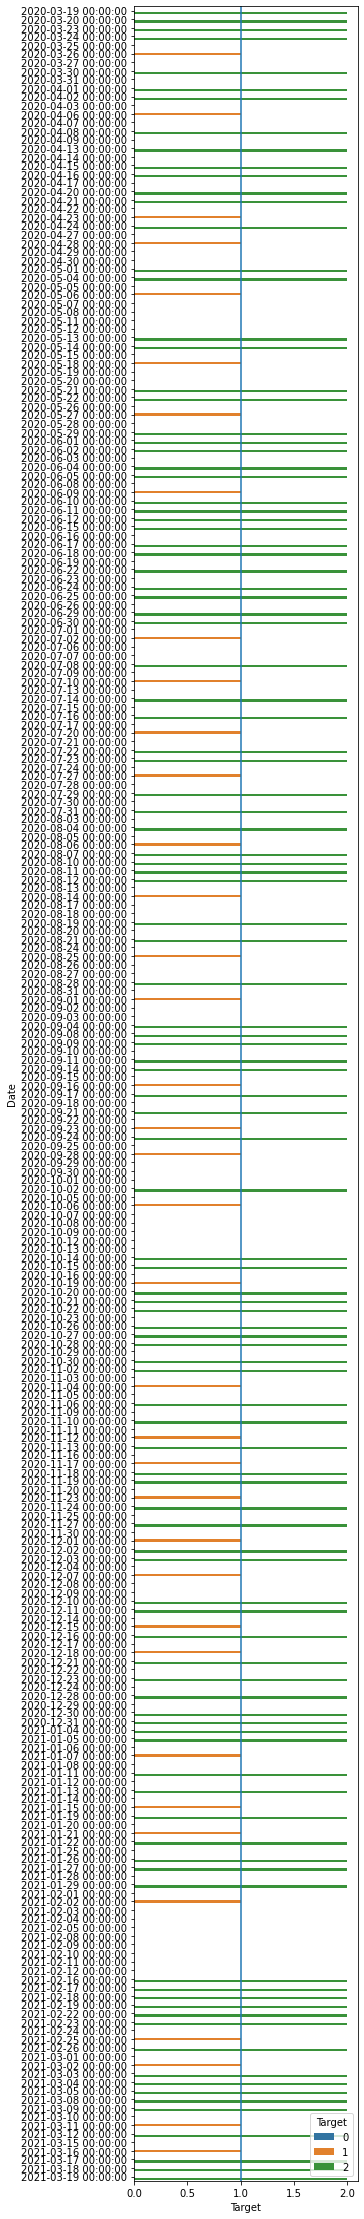

In [53]:
colors=[]
[colors.append('Red') if x=='2' else colors.append('Green') if x==1 else colors.append('White') for x in df['Target']]
plt.figure(figsize=(4, 40))
#names.arg = colors
sns.barplot(data=df, x='Target', y=df.index, hue='Target')
plt.axvline(x=1, ymin=0, ymax=1)
plt.show()

    Buy_Count  Incidence  Size
0           0          2   112
1           1          0    62
2           2          1    37
3           3          0    19
4           4          0    11
5           5          0     4
6           6          0     3
7           7          0     2
8           8          0     1
9           9          0     1
10         10          0     1
Number of Buys in the Data 19
Number of days holding Open          42
High          42
Low           42
Close         42
Adj Close     42
Volume        42
Shifted 1D    42
Shifted 2D    42
Open_PCT      42
Buy_Count     42
Action        42
Target        42
dtype: int64
Incidence shows the average target value for each group


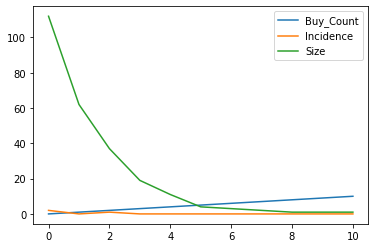

In [54]:
def create_pig_table(basetable, target, variable):
  
    # Create groups for each variable
    groups = basetable[[target,variable]].groupby(variable)
    
    pig_table=groups[target].agg([np.mean, np.size]).reset_index()
    pig_table=pig_table.rename(columns={'mean':'Incidence','size':'Size'})
    #pig_table = groups[target].agg({'Incidence' : np.mean, 'Size' : np.size}).reset_index()

    # Return the predictor insight graph table
    return pig_table

pig_table = create_pig_table(df, "Target", "Buy_Count")
print(pig_table)

print("Number of Buys in the Data", len(df[df['Buy_Count']==3]))

print("Number of days holding", df[(df["Action"]=='Hold')].count())

print("Incidence shows the average target value for each group")

pig_table.plot()
plt.show()

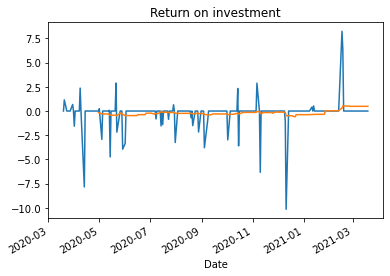

In [55]:
#df['Return']=df[df['Open']]
sellAmt=0
sellIndex=0
buyAmt=0
df['Return']=0
previousAction=""
for index in range(len(df)):
    count=0
    for index2 in (range(index,0,-1)):
        row=df.iloc[index2]
        #Print(row.Action, row.Open, row.Return)
        if row.Action=='Sell':
            if previousAction=='Sell':
                break
            sellAmt=row.Open
            sellIndex=index2
        if row.Action=='Buy' and (previousAction=='Hold' or previousAction=='Sell'):
            #print("Buy", sellIndex,index2)
            buyAmt=row.Open
            #print("Return",  previousAction, buyAmt,sellAmt,index2,sellIndex)
            df.iloc[sellIndex, df.columns.get_loc('Return')]=sellAmt-buyAmt
            break
        if row.Action=='No Action':
            break
        previousAction=row.Action
            
    #df.iloc[index, df.columns.get_loc('Buy_Count')]=count

#for key,item in df.iterrows():
#    print(item.Action,item.Open, "Return", item.Return)


df['Return_Avg'] = df['Return'].rolling(
    window=30,
    center=False
).mean()

df['Return'].plot()
df['Return_Avg'].plot()
plt.title('Return on investment')
plt.show()

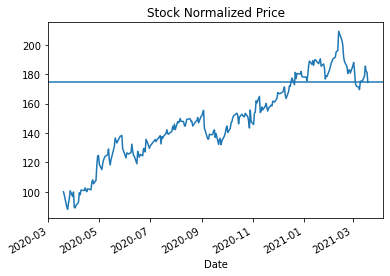

In [56]:
first_price=df['Open'].iloc[0]
last_price=df['Open'].iloc[len(df)-1]/first_price*100

normalized=df.Open.div(first_price).mul(100)
normalized.plot(title='Stock Normalized Price')
plt.axhline(y=last_price, xmin=0, xmax=1)
plt.show()


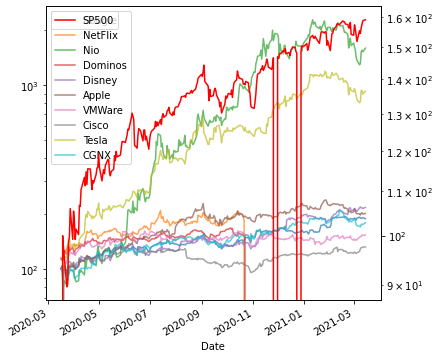

In [57]:
google['Normalized']=google['Open'].div(google['Open'].iloc[0]).mul(100)
microsoft['Normalized']=microsoft['Open'].div(microsoft['Open'].iloc[0]).mul(100)
tesla['Normalized']=tesla['Open'].div(tesla['Open'].iloc[0]).mul(100)
nio['Normalized']=nio['Open'].div(nio['Open'].iloc[0]).mul(100)
netflix['Normalized']=netflix['Open'].div(netflix['Open'].iloc[0]).mul(100)
dominos['Normalized']=dominos['Open'].div(dominos['Open'].iloc[0]).mul(100)
disney['Normalized']=disney['Open'].div(disney['Open'].iloc[0]).mul(100)
apple['Normalized']=apple['Open'].div(apple['Open'].iloc[0]).mul(100)
vmware['Normalized']=vmware['Open'].div(vmware['Open'].iloc[0]).mul(100)
sp500['Normalized']=sp500['Open'].div(sp500['Open'].iloc[0]).mul(100)
cisco['Normalized']=cisco['Open'].div(cisco['Open'].iloc[0]).mul(100)
cgnx['Normalized']=cgnx['Open'].div(cgnx['Open'].iloc[0]).mul(100)


compare=google.merge(microsoft['Normalized'],on='Date',how='left').rename(columns={'Normalized_x':'Google','Normalized_y':'Microsoft'}).drop(columns=['Volume','High','Low','Close','Adj Close']).fillna(0)
compare=compare.merge(netflix['Normalized'],on='Date',how='left').rename(columns={'Normalized':'NetFlix'}).fillna(0)
compare=compare.merge(nio['Normalized'],on='Date',how='left').rename(columns={'Normalized':'Nio'}).fillna(0)
compare=compare.merge(tesla['Normalized'],on='Date',how='left').rename(columns={'Normalized':'Tesla'}).fillna(0)
compare=compare.merge(dominos['Normalized'],on='Date',how='left').rename(columns={'Normalized':'Dominos'}).fillna(0)
compare=compare.merge(disney['Normalized'],on='Date',how='left').rename(columns={'Normalized':'Disney'}).fillna(0)
compare=compare.merge(apple['Normalized'],on='Date',how='left').rename(columns={'Normalized':'Apple'}).fillna(0)
compare=compare.merge(vmware['Normalized'],on='Date',how='left').rename(columns={'Normalized':'VMWare'}).fillna(0)
compare=compare.merge(sp500['Normalized'],on='Date',how='left').rename(columns={'Normalized':'SP500'}).fillna(0)
compare=compare.merge(cisco['Normalized'],on='Date',how='left').rename(columns={'Normalized':'Cisco'}).fillna(0)
compare=compare.merge(cgnx['Normalized'],on='Date',how='left').rename(columns={'Normalized':'CGNX'}).fillna(0)

#print(compare)

#compare=compare.div(compare.iloc[0]).mul(100)

tickers=['Google','NetFlix','Nio','Dominos','Disney','Apple','VMWare','Cisco','Tesla','CGNX']
#tickers=['Nio','Tesla']
#print(compare)
fig,ax=plt.subplots(figsize=(6,6))
plt.yscale("log")
compare[tickers].plot(ax=ax,alpha=.7)
twin_ax=ax.twinx()
compare[['SP500']].plot(ax=twin_ax, c='red')
plt.yscale("log")
plt.show()


In [12]:
dates = pd.date_range(start='2021', periods=4, freq='Q')

data=range(1,5)

quarterly = pd.Series(data=data, index=dates)
print(quarterly)

monthly=quarterly.asfreq('M')
print(monthly)

2021-03-31    1
2021-06-30    2
2021-09-30    3
2021-12-31    4
Freq: Q-DEC, dtype: int64
2021-03-31    1.0
2021-04-30    NaN
2021-05-31    NaN
2021-06-30    2.0
2021-07-31    NaN
2021-08-31    NaN
2021-09-30    3.0
2021-10-31    NaN
2021-11-30    NaN
2021-12-31    4.0
Freq: M, dtype: float64


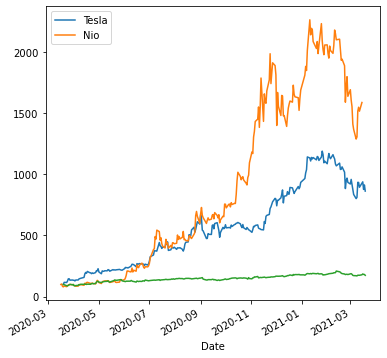

In [60]:

#print(compare)
fig,ax=plt.subplots(figsize=(6,6))
tesla['Normalized'].plot(ax=ax)
nio['Normalized'].plot(ax=ax)
cgnx['Normalized'].plot(ax=ax)
plt.legend(['Tesla','Nio'])
plt.show()
